In [ ]:
!pip install contractions wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 14.3 MB/s 
     |████████████████████████████████| 106 kB 44.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import string
import re
import contractions
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_table('https://raw.githubusercontent.com/naveenkarya/SMSSpamDetection/main/SMSSpamCollection', sep='\t', header=None, names=['label', 'sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [ ]:
# Number of data points in dataset
df.shape[0]

5572

In [ ]:
# Class distribution
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
# Min, max, average length of ham and spam SMS messages
min_sms_len = df['sms_message'].str.len().groupby(df.label).min()
max_sms_len = df['sms_message'].str.len().groupby(df.label).max()
mean_sms_len = df['sms_message'].str.len().groupby(df.label).mean()
stdev_sms_len = df['sms_message'].str.len().groupby(df.label).std()

print(f'''Minimum message length: {min_sms_len}\n
Max message length: {max_sms_len}\n
Avg message length: {mean_sms_len}\n
Standard dev message length: {stdev_sms_len}''')

Minimum message length: label
ham      2
spam    13
Name: sms_message, dtype: int64

Max message length: label
ham     910
spam    223
Name: sms_message, dtype: int64

Avg message length: label
ham      71.482487
spam    138.670683
Name: sms_message, dtype: float64

Standard dev message length: label
ham     58.440652
spam    28.873603
Name: sms_message, dtype: float64


In [ ]:
# Check if there are null values in dataset
df.isnull().sum()

label          0
sms_message    0
dtype: int64

## Data Preprocessing

In [ ]:
# Assign labels as binary values to run regression (spam = 1, ham = 0)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})
df.head()

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
import contractions
stop_words = stopwords.words('english')
def preprocess_data(msg):
    # Expand contractions
    msg = contractions.fix(msg)
    # Convert to lowercase & remove punctuations
    msg = "".join([word.lower() for word in msg if word not in string.punctuation]) 
    # Remove numbers and non-alphabetical letters
    msg = re.sub('[^a-zA-Z]+', ' ', msg)
    # Remove stopwords
    tokens = [word for word in msg.split() if word not in stop_words]
    return " ".join(tokens)

df['sms_message'] = df['sms_message'].apply(lambda x: preprocess_data(x))
df.head()

,label,sms_message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor c already say
4,0,nah think goes usf lives around though


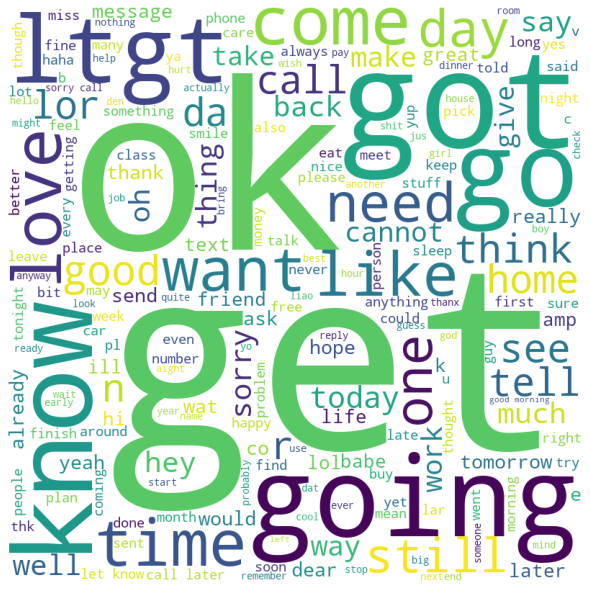

In [ ]:
# Generate ham word cloud 
text = " ".join(text for text in df[df['label'] == 0]['sms_message'])
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(text)
# plot the WordCloud                       
plt.figure(figsize = (10,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

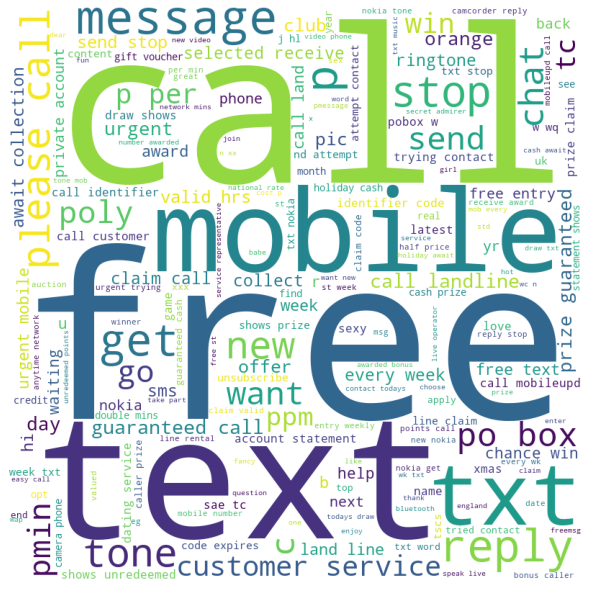

In [ ]:
# Generate spam word cloud 
text = " ".join(text for text in df[df['label'] == 1]['sms_message'])
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(text)
# plot the WordCloud                       
plt.figure(figsize = (10,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
from collections import Counter
ham_counts = Counter([token for tokens in df[df['label'] == 0]['sms_message'].str.split() for token in tokens])
print(ham_counts.most_common(15))
spam_counts = Counter([token for tokens in df[df['label'] == 1]['sms_message'].str.split() for token in tokens])
print(spam_counts.most_common(15))

[('get', 309), ('ltgt', 276), ('ok', 273), ('know', 267), ('go', 253), ('got', 245), ('going', 232), ('like', 231), ('call', 231), ('come', 228), ('good', 224), ('love', 222), ('day', 195), ('want', 193), ('time', 189)]
[('call', 362), ('free', 221), ('txt', 153), ('mobile', 125), ('text', 121), ('stop', 120), ('claim', 113), ('reply', 101), ('p', 94), ('prize', 92), ('get', 83), ('nokia', 70), ('new', 69), ('win', 68), ('send', 68)]


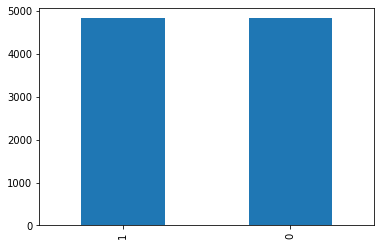

In [ ]:
# Apply oversampling to fix class imbalance
ham_count, spam_count = df['label'].value_counts()
ham = df[df['label'] == 0]
spam = df[df['label'] == 1]

spam_oversampled = spam.sample(ham_count, replace=True)
oversampled_df = pd.concat([spam_oversampled, ham], axis=0)
oversampled_df.reset_index(inplace=True, drop=True)
oversampled_df['label'].value_counts().plot(kind='bar')

In [ ]:
oversampled_df.head()

,label,sms_message
0,1,urgent mobile number awarded prize guaranteed ...
1,1,babe want baby nasty thing filthyguys fancy ru...
2,1,rock yr chik get filthy films xxx pics yr phon...
3,1,cmon babe make horny turn txt fantasy babe hot...
4,1,free messagewe billed mobile number mistake sh...


In [ ]:
oversampled_df.shape

(9650, 2)

## Train models

In [ ]:
# Split dataset into 80% train / 20% test
train = oversampled_df.groupby('label').sample(frac=0.8)
test = oversampled_df.loc[oversampled_df.index.difference(train.index)]

In [ ]:
# Create feature matrix
vectorizer = TfidfVectorizer()
X_feat_mat = vectorizer.fit_transform(train['sms_message'])

In [ ]:
# Create test matrix
x_tst_mat = vectorizer.transform(test['sms_message'])

In [ ]:
# Train multiple models
def train_models(models, Xtrain, Ytrain):
    for model_name, model in models.items():
        model.fit(Xtrain, Ytrain)
        

In [ ]:
# Pick K for KNN using cross-validation
k_to_scores = {}
k_to_scores_std = {}
for num in range(1, 70):
    knn = KNeighborsClassifier(n_neighbors=num, weights='distance')
    scores = cross_val_score(knn, X_feat_mat, train['label'], cv=5)
    k_to_scores[num] = np.mean(scores)
    k_to_scores_std[num] = np.std(scores)

In [ ]:
sorted(k_to_scores.items(), key = lambda x : x[1], reverse=True)[0:20]

[(18, 0.9974093264248705),
 (19, 0.9972797927461141),
 (20, 0.9972797927461141),
 (1, 0.9971502590673575),
 (2, 0.9971502590673575),
 (21, 0.9971502590673575),
 (17, 0.997020725388601),
 (3, 0.9968911917098445),
 (4, 0.9968911917098445),
 (5, 0.9968911917098445),
 (22, 0.9968911917098445),
 (8, 0.9967616580310882),
 (9, 0.9967616580310882),
 (10, 0.9967616580310882),
 (15, 0.9967616580310882),
 (16, 0.9967616580310882),
 (23, 0.9967616580310882),
 (6, 0.9966321243523316),
 (7, 0.9966321243523316),
 (11, 0.9963730569948186)]

In [ ]:
k_to_scores_std[4]

0.001757080306509143

All K values have similar scores. We can use any K. Let's use 4-KNN.

In [ ]:
# Pick regularization parameter for SVM using cross-validation
c_to_scores = {}
for num in range(1, 40, 2):
    svc = SVC(C=num)
    scores = cross_val_score(svc, X_feat_mat, train['label'], cv=5)
    c_to_scores[num] = np.mean(scores)

In [ ]:
c_to_scores

{1: 0.9979274611398964,
 3: 0.9979274611398964,
 5: 0.9979274611398964,
 7: 0.9979274611398964,
 9: 0.9979274611398964,
 11: 0.9979274611398964,
 13: 0.9979274611398964,
 15: 0.9979274611398964,
 17: 0.9979274611398964,
 19: 0.9979274611398964,
 21: 0.9979274611398964,
 23: 0.9979274611398964,
 25: 0.9979274611398964,
 27: 0.9979274611398964,
 29: 0.9979274611398964,
 31: 0.9979274611398964,
 33: 0.9979274611398964,
 35: 0.9979274611398964,
 37: 0.9979274611398964,
 39: 0.9979274611398964}

Scores are slightly better when C >= 5. We can use C = 5 for SVM

In [ ]:
# Pick regularization parameter for Logistic Regression using cross-validation
c_to_scores = {}
for num in range(1, 40, 2):
    lgr = LogisticRegression(C=num)
    scores = cross_val_score(lgr, X_feat_mat, train['label'], cv=5)
    c_to_scores[num] = np.mean(scores)

In [ ]:
c_to_scores

{1: 0.9852331606217616,
 3: 0.993782383419689,
 5: 0.9949481865284973,
 7: 0.9955958549222798,
 9: 0.9958549222797928,
 11: 0.9958549222797928,
 13: 0.9958549222797928,
 15: 0.9961139896373057,
 17: 0.9962435233160623,
 19: 0.9963730569948186,
 21: 0.996502590673575,
 23: 0.996502590673575,
 25: 0.996502590673575,
 27: 0.9963730569948186,
 29: 0.9963730569948186,
 31: 0.9963730569948186,
 33: 0.9963730569948186,
 35: 0.9963730569948186,
 37: 0.9963730569948186,
 39: 0.9963730569948186}

Scores are slightly better when C >= 9. We can use C = 9 for Logistic Regression

In [ ]:
lgr = SVC(C=400)
np.mean(cross_val_score(lgr, X_feat_mat, train['label'], cv=5))

0.9979274611398964

In [ ]:
# Initialize models
logr = LogisticRegression(C=9)
knn4 = KNeighborsClassifier(4)
mnb = MultinomialNB()
svm = SVC(C=5)
models = {"LogisticRegression": logr, "4-KNN": knn4, "Naive-Bayes": mnb, "SVM": svm}

In [ ]:
# Train models
train_models(models, X_feat_mat, train['label'])

## Predict

In [ ]:
def predict(models, Xtest):
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict(Xtest)
    return predictions

In [ ]:
predictions = predict(models, x_tst_mat)

## Analyze model performance

In [ ]:
# Create confusion matrix and calculate performance metrics
def evaluate_models(actual, predictions):
    results = {}
    for model_name, prediction in predictions.items():
        mat = metrics.confusion_matrix(actual, prediction)
        tn,fp = mat[0]
        fn,tp = mat[1]
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        results[model_name] = {"TP": tp,
                               "FP": fp,
                               "FN": fn,
                               "TN": tn,
                               "Accuracy": (tp + tn)/(tp + fp + tn + fn), 
                               "Precision": precision,
                               "Recall": recall,
                               "F-Measure": (2 * precision * recall)/(precision + recall),
                               "conf-mat": mat}
    return results

In [ ]:
results = evaluate_models(test['label'], predictions)

In [ ]:
res_df = pd.DataFrame(results)
res_df_t = res_df[~res_df.index.isin(['conf-mat'])].T
res_df_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
LogisticRegression,963,11,2,954,0.993264,0.988706,0.997927,0.993296
4-KNN,920,2,45,963,0.975648,0.997831,0.953368,0.975093
Naive-Bayes,951,30,14,935,0.977202,0.969419,0.985492,0.97739
SVM,963,6,2,959,0.995855,0.993808,0.997927,0.995863


## Text Encoding SMS Messages (In-Progress)

In [ ]:
# Word2Vec
from gensim.models import Word2Vec
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
model.most_similar(positive=["king", "woman"], negative='man')